In [1]:
import math
import numbers
import torch
from torch import nn
from torch.nn import functional as F


class GaussianSmoothing(nn.Module):
    """
    对1d、2d或3d张量应用高斯平滑。
    使用深度可分离卷积对输入的每个通道分别进行滤波处理。
    
    参数说明:
        channels: 输入张量的通道数，输出将保持相同的通道数
        kernel_size: 高斯核的大小
        sigma: 高斯核的标准差
        dim: 数据的维度，默认为2（空间维度）
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        # 如果kernel_size是单个数字，则扩展为dim维的列表
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        # 如果sigma是单个数字，则扩展为dim维的列表
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # 生成高斯核：最终的核是每个维度高斯函数的乘积
        kernel = 1
        # 创建网格点坐标，用于计算高斯核
        meshgrids = torch.meshgrid([torch.arange(size, dtype=torch.float32) for size in kernel_size])

        # 对每个维度计算高斯分布
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2  # 计算核的中心点
            # 计算高斯函数：f(x) = (1/σ√(2π)) * e^(-(x-μ)²/2σ²)
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

        # 归一化核，确保所有值的和为1
        kernel = kernel / torch.sum(kernel)

        # 重塑核的形状以用于深度可分离卷积
        # 添加两个维度：第一个用于输出通道，第二个用于输入通道
        kernel = kernel.view(1, 1, *kernel.size())
        # 在通道维度上重复核，使其匹配输入通道数
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        # 注册核为缓冲区（不会被优化器更新）
        self.register_buffer('weight', kernel)
        self.groups = channels  # 设置分组卷积的组数，等于通道数

        # 根据维度选择适当的卷积操作
        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        对输入应用高斯滤波
        
        参数:
            input: 需要应用高斯滤波的输入张量
            
        返回:
            filtered: 经过滤波后的输出张量
        """
        # 执行分组卷积操作，确保权重的dtype与输入一致
        return self.conv(input, weight=self.weight.to(input.dtype), groups=self.groups)

/home/zhouyufan/anaconda3/envs/ldm/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


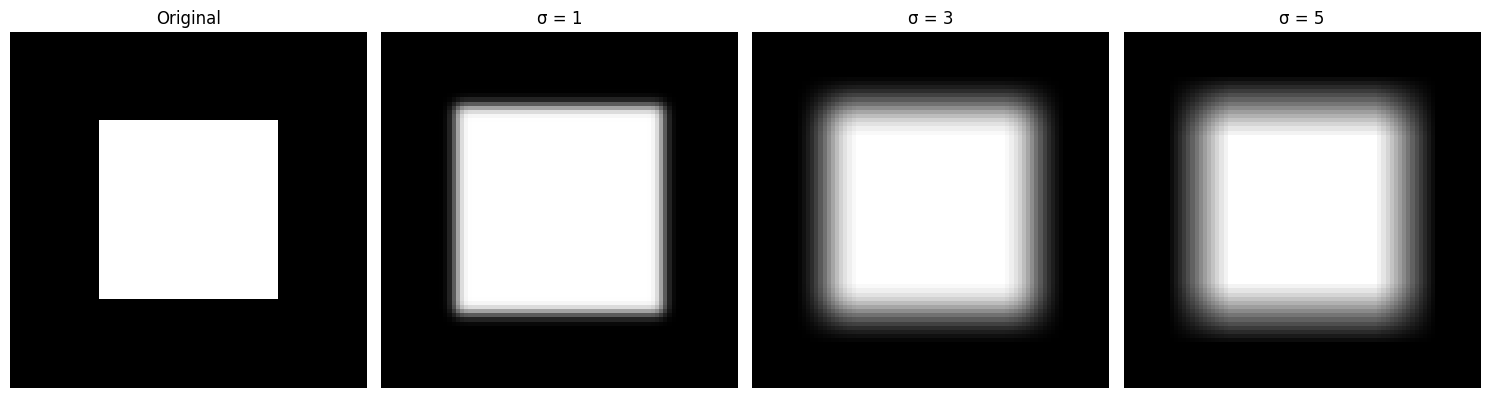

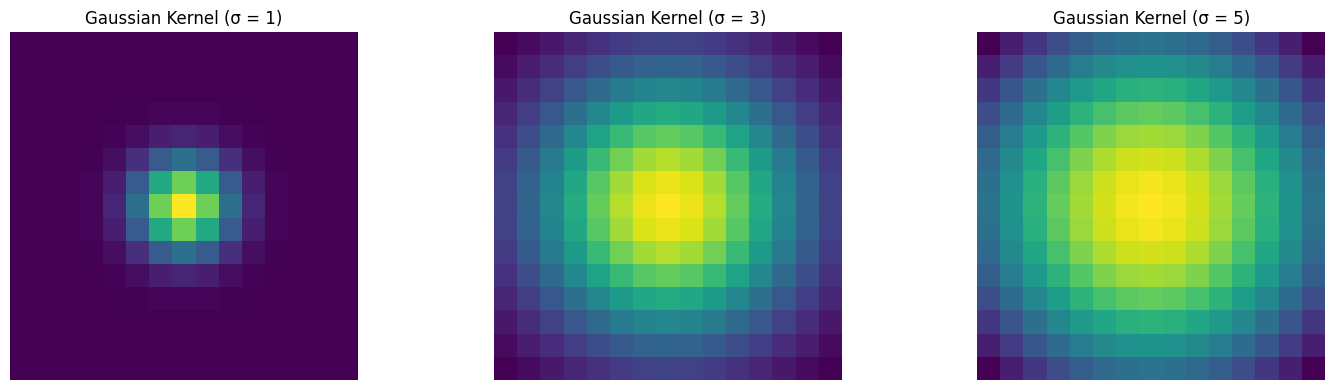

In [2]:
# ... (保持原有的 import 和 GaussianSmoothing 类不变) ...

# 添加新的代码单元格用于可视化
import matplotlib.pyplot as plt
import numpy as np

# 创建一个测试函数来可视化高斯平滑效果
def visualize_gaussian_smoothing():
    # 1. 创建一个简单的测试图像（黑白方格图案）
    size = 100
    test_image = np.zeros((size, size))
    test_image[size//4:3*size//4, size//4:3*size//4] = 1.0
    
    # 2. 转换为PyTorch张量并添加批次和通道维度
    input_tensor = torch.from_numpy(test_image).float()
    input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, H, W]
    
    # 3. 创建不同sigma值的高斯平滑器
    sigmas = [1, 3, 5]
    kernel_size = 15
    
    # 4. 创建子图
    fig, axes = plt.subplots(1, len(sigmas) + 1, figsize=(15, 4))
    
    # 显示原始图像
    axes[0].imshow(test_image, cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # 对每个sigma值应用高斯平滑并显示结果
    for i, sigma in enumerate(sigmas):
        # 创建高斯平滑器
        smoother = GaussianSmoothing(channels=1, kernel_size=kernel_size, sigma=sigma)
        
        # 应用平滑
        with torch.no_grad():
            smoothed = smoother(input_tensor)
        
        # 显示结果
        smoothed_image = smoothed.squeeze().numpy()
        axes[i+1].imshow(smoothed_image, cmap='gray')
        axes[i+1].set_title(f'σ = {sigma}')
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 可视化高斯核
    fig, axes = plt.subplots(1, len(sigmas), figsize=(15, 4))
    for i, sigma in enumerate(sigmas):
        smoother = GaussianSmoothing(channels=1, kernel_size=kernel_size, sigma=sigma)
        kernel = smoother.weight.squeeze().numpy()
        
        axes[i].imshow(kernel, cmap='viridis')
        axes[i].set_title(f'Gaussian Kernel (σ = {sigma})')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 运行可视化
visualize_gaussian_smoothing()

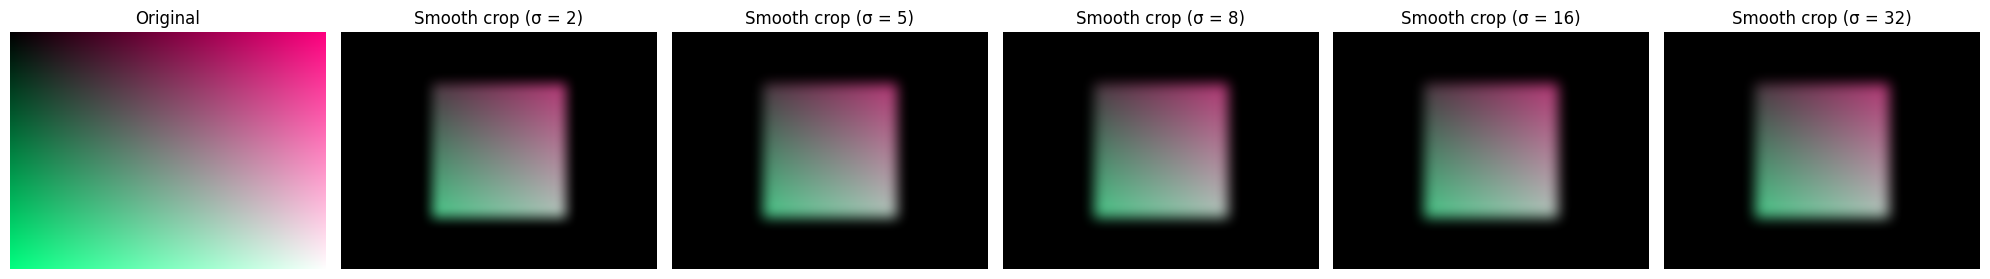

In [9]:
def create_smooth_mask(size, border_width=30):
    """
    创建一个带有平滑边缘的mask
    
    参数:
        size: (height, width) 表示mask的尺寸，这里是裁剪区域的大小
        border_width: 边缘过渡带的宽度，默认30像素
        
    返回:
        带有平滑边缘的二维numpy数组，值范围在0-1之间
    """
    h, w = size  # 解包高度和宽度
    mask = np.ones((h, w))  # 创建全1的mask
    
    # 创建一个余弦过渡函数，生成border_width个点
    x = np.linspace(0, 1, border_width)
    # 使用余弦函数创建平滑的过渡：从1平滑过渡到0
    gradient = 0.5 * (1 + np.cos(np.pi * (1 - x)))
    
    # 确保边框宽度不超过图像尺寸的一半
    border_width = min(border_width, h//2, w//2)
    
    # 应用渐变到四个边缘
    for i in range(border_width):
        # 上边缘
        mask[i, :] *= gradient[i]
        # 下边缘
        mask[-(i+1), :] *= gradient[i]
        # 左边缘
        mask[:, i] *= gradient[i]
        # 右边缘
        mask[:, -(i+1)] *= gradient[i]
    
    return mask

def smooth_crop_image(image_path, crop_coords, sigma=3):
    """
    平滑裁剪图像的边缘
    
    参数:
    image_path: 图像路径
    crop_coords: 裁剪坐标 (x1, y1, x2, y2)
    sigma: 高斯模糊的标准差
    """
    # 加载图像
    img = Image.open(image_path)
    img_array = np.array(img)
    h, w = img_array.shape[:2]
    
    # 创建裁剪mask
    mask = np.zeros((h, w), dtype=np.float32)
    x1, y1, x2, y2 = crop_coords
    mask[y1:y2, x1:x2] = 1
    
    # 创建平滑mask
    smooth_edge = create_smooth_mask((y2-y1, x2-x1), border_width=30)
    mask[y1:y2, x1:x2] *= smooth_edge
    
    # 转换为PyTorch张量
    mask_tensor = torch.from_numpy(mask).unsqueeze(0).unsqueeze(0).float()
    
    # 应用高斯平滑
    smoother = GaussianSmoothing(channels=1, kernel_size=15, sigma=sigma)
    
    # 添加padding以保持尺寸
    padding = (15 - 1) // 2
    mask_tensor = F.pad(mask_tensor, (padding, padding, padding, padding), mode='reflect')
    
    with torch.no_grad():
        smooth_mask = smoother(mask_tensor)
    
    # 转回numpy并扩展到3个通道
    smooth_mask = smooth_mask.squeeze().numpy()
    smooth_mask = np.stack([smooth_mask] * 3, axis=-1)
    
    # 应用mask到图像
    result = img_array * smooth_mask
    
    return result.astype(np.uint8)

def visualize_smooth_crop():
    # 创建一个示例图像
    size = (300, 400, 3)
    # 创建一个更有意义的测试图像（渐变色背景）
    x = np.linspace(0, 1, size[1])
    y = np.linspace(0, 1, size[0])
    X, Y = np.meshgrid(x, y)
    
    test_image = np.zeros(size)
    test_image[:,:,0] = X
    test_image[:,:,1] = Y
    test_image[:,:,2] = (X + Y) / 2
    test_image = (test_image * 255).astype(np.uint8)
    
    test_image_path = "test_image.png"
    Image.fromarray(test_image).save(test_image_path)
    
    # 定义裁剪区域
    crop_coords = (100, 50, 300, 250)  # (x1, y1, x2, y2)
    
    # 应用不同程度的平滑
    sigmas = [2, 5, 8,16,32]
    
    # 创建可视化
    fig, axes = plt.subplots(1, len(sigmas) + 1, figsize=(20, 5))
    
    # 显示原始图像
    axes[0].imshow(test_image)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # 显示不同sigma值的结果
    for i, sigma in enumerate(sigmas):
        result = smooth_crop_image(test_image_path, crop_coords, sigma)
        axes[i+1].imshow(result)
        axes[i+1].set_title(f'Smooth crop (σ = {sigma})')
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()

# 运行可视化
visualize_smooth_crop()